## Triplets Dataset Creation

In [1]:
!wget http://imagenet.stanford.edu/internal/jcjohns/scene_graphs/sg_dataset.zip

--2019-10-31 21:11:31--  http://imagenet.stanford.edu/internal/jcjohns/scene_graphs/sg_dataset.zip
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2000609775 (1.9G) [application/zip]
Saving to: ‘sg_dataset.zip’

sg_dataset.zip      100%[===================>]   1.86G  12.3MB/s    in 2m 25s  

2019-10-31 21:13:56 (13.2 MB/s) - ‘sg_dataset.zip’ saved [2000609775/2000609775]



In [2]:
!unzip sg_dataset.zip

Archive:  sg_dataset.zip
   creating: sg_dataset/
  inflating: sg_dataset/sg_test_annotations.json  
   creating: sg_dataset/sg_test_images/
  inflating: sg_dataset/sg_test_images/10002158834_6dd6c6667f_b.jpg  
  inflating: sg_dataset/sg_test_images/10003466765_d20a7655c6_b.jpg  
  inflating: sg_dataset/sg_test_images/10008170616_a54deca9e3_b.jpg  
  inflating: sg_dataset/sg_test_images/10050248663_2cdb49c115_b.jpg  
  inflating: sg_dataset/sg_test_images/1006083276_0c1a4345fb_o.jpg  
  inflating: sg_dataset/sg_test_images/10085008474_8d72a9dc5e_b.jpg  
  inflating: sg_dataset/sg_test_images/10104268563_965a646010_b.jpg  
  inflating: sg_dataset/sg_test_images/10132007626_6421a783be_b.jpg  
  inflating: sg_dataset/sg_test_images/10132084253_cfa22219a1_b.jpg  
  inflating: sg_dataset/sg_test_images/10142659205_1158853119_b.jpg  
  inflating: sg_dataset/sg_test_images/10142737776_a40de33ab1_b.jpg  
  inflating: sg_dataset/sg_test_images/10161340284_8a72090a5b_b.jpg  
  inflating: sg_data

In [0]:
!mkdir triplets_dataset

In [0]:
#If positive example is (man, next to, bus)
#The negative example will be like (man, leaning on, bus)

import json
import imageio

def createTripletExamples(predicate, filename):

  #From here on you don't need to change anything
  if(filename=="sg_dataset/sg_test_annotations.json"):
      newFilename = str("triplets_dataset/"+predicate+'_test_triplets.json')
  else:
      newFilename = str("triplets_dataset/"+predicate + '_train_triplets.json')

  data = {'predicate': predicate, 'examples': []}
  def addToData(filename1, filename2, p_bbox1, p_bbox2, n_bbox1, n_bbox2, p_name1, p_name2, n_name1, n_name2, relationship_p, relationship_n):
      row = {}
      row['filename1'] = filename1
      row['filename2'] = filename2

      row['positive'] = {}
      row['negative'] = {}

      row['positive']['bbox1'] = p_bbox1
      row['positive']['bbox2'] = p_bbox2
      row['positive']['obj1'] = p_name1
      row['positive']['obj2'] = p_name2
      row['positive']['relationship'] = relationship_p

      row['negative']['bbox1'] = n_bbox1
      row['negative']['bbox2'] = n_bbox2
      row['negative']['obj1'] = n_name1
      row['negative']['obj2'] = n_name2
      row['negative']['relationship'] = relationship_n

      data['examples'].append(row)


  def getDistance(bb1, bb2):
      bb1_x1 = bb1['x']
      bb1_y1 = bb1['y']
      bb1_w = bb1['w']
      bb1_h = bb1['h']
      bb1_x2 = bb1_x1+bb1_w
      bb1_y2 = bb1_y1+bb1_h

      bb2_x1 = bb2['x']
      bb2_y1 = bb2['y']
      bb2_w = bb2['w']
      bb2_h = bb2['h']
      bb2_x2 = bb2_x1 + bb2_w
      bb2_y2 = bb2_y1 + bb2_h

      dx = min(bb1_x1-bb2_x1, bb1_x1-bb2_x2, bb1_x2-bb2_x1, bb1_x2-bb2_x2)
      dy = min(bb1_y1 - bb2_y1, bb1_y1 - bb2_y2, bb1_y2 - bb2_y1, bb1_y2 - bb2_y2)
      return dx**2 + dy**2

  filter = "JSON file (*.json)|*.json|All Files (*.*)|*.*||"

  #Read JSON data into the datastore variable
  if filename:
      with open(filename, 'r') as f:
          datastore = json.load(f)

          for it in range(len(datastore)):
              for i in range(len(datastore[it]['relationships'])):
                  row = datastore[it]['relationships'][i]
                  if(row['relationship']==predicate):
                      obj1 = row['objects'][0]
                      obj2 = row['objects'][1]
                      p_bb1 = datastore[it]['objects'][obj1]['bbox']
                      p_bb2 = datastore[it]['objects'][obj2]['bbox']
                      p_objname1 = datastore[it]['objects'][obj1]['names'][0]
                      p_objname2 = datastore[it]['objects'][obj2]['names'][0]

                      for it2 in range(it+1, len(datastore)):
                          nearest2obj1 = -1
                          dist_obj1 = -1
                          nearest2obj2 = -1
                          dist_obj2 = -1
                          for j in range(len(datastore[it2]['relationships'])):
                              row = datastore[it2]['relationships'][j]
                              if(datastore[it2]['objects'][row['objects'][0]]['names'][0]==datastore[it]['objects'][obj1]['names'][0]
                                      and datastore[it2]['objects'][row['objects'][1]]['names'][0]==datastore[it]['objects'][obj2]['names'][0]
                                      and row['relationship']!=predicate):
                                  n_bb1 = datastore[it2]['objects'][row['objects'][0]]['bbox']
                                  n_bb2 = datastore[it2]['objects'][row['objects'][1]]['bbox']
                                  n_objname1 = datastore[it2]['objects'][row['objects'][0]]['names'][0]
                                  n_objname2 = datastore[it2]['objects'][row['objects'][1]]['names'][0]
                                  addToData(datastore[it]['filename'], datastore[it2]['filename'], p_bb1, p_bb2, n_bb1, n_bb2, p_objname1, p_objname2,n_objname1, n_objname2, predicate, row['relationship'])
                              elif(datastore[it2]['objects'][row['objects'][0]]['names'][0]==datastore[it]['objects'][obj2]['names'][0]
                                      and datastore[it2]['objects'][row['objects'][1]]['names'][0]==datastore[it]['objects'][obj1]['names'][0]
                                      and row['relationship']!=predicate):
                                  n_bb1 = datastore[it2]['objects'][row['objects'][1]]['bbox']
                                  n_bb2 = datastore[it2]['objects'][row['objects'][0]]['bbox']
                                  n_objname1 = datastore[it2]['objects'][row['objects'][1]]['names'][0]
                                  n_objname2 = datastore[it2]['objects'][row['objects'][0]]['names'][0]
                                  addToData(datastore[it]['filename'], datastore[it2]['filename'], p_bb1, p_bb2, n_bb1, n_bb2, p_objname1, p_objname2,n_objname1, n_objname2, predicate, row['relationship'])

  with open(newFilename, 'w') as f:
      json.dump(data, f)


In [0]:
#Just change this based on the file and predicate used
predicate = 'on'
filename = "sg_dataset/sg_test_annotations.json"

createTripletExamples(predicate, filename)

## Triplets Dataset Visualization

In [0]:
import imageio
import matplotlib.pyplot as plt
import numpy as np


def visualizeDataset(filename, numExamples=10):

  #No need to make changes from here
  def getCoordinates(bbox):
      x = bbox['x']
      y = bbox['y']
      w = bbox['w']
      h = bbox['h']

      x2 = x+w
      y2 = y+h

      x_coordinates = np.array([x,x,x2,x2,x])
      y_coordinates = np.array([y,y2,y2,y,y])
      return x_coordinates, y_coordinates

  import json
  filter = "JSON file (*.json)|*.json|All Files (*.*)|*.*||"

  #Read JSON data into the datastore variable
  if filename:
      with open(filename, 'r') as f:
          datastore = json.load(f)
          print("Total Positive Negative Example Pairs for this predicate = ",len(datastore['examples']))
          for it in range(min(len(datastore['examples']),numExamples)):
              filename1 = datastore['examples'][it]['filename1']
              filename2 = datastore['examples'][it]['filename2']

              p_bb1 = datastore['examples'][it]['positive']['bbox1']
              p_bb2 = datastore['examples'][it]['positive']['bbox2']
              n_bb1 = datastore['examples'][it]['negative']['bbox1']
              n_bb2 = datastore['examples'][it]['negative']['bbox2']

              p_obj1 = datastore['examples'][it]['positive']['obj1']
              p_obj2 = datastore['examples'][it]['positive']['obj2']
              n_obj1 = datastore['examples'][it]['negative']['obj1']
              n_obj2 = datastore['examples'][it]['negative']['obj2']

              p_pred = datastore['examples'][it]['positive']['relationship']
              n_pred = datastore['examples'][it]['negative']['relationship']

              img1 = imageio.imread("sg_dataset/sg_test_images/"+filename1)
              img2 = imageio.imread("sg_dataset/sg_test_images/"+filename2)


              plt.subplot(121)
              plt.title("Positive Example: \n"+p_obj1+", "+p_pred+", "+p_obj2)
              plt.imshow(img1)
              coordinates_x, coordinates_y = getCoordinates(p_bb1)
              plt.plot(coordinates_x, coordinates_y, 'b-')
              coordinates_x, coordinates_y = getCoordinates(p_bb2)
              plt.plot(coordinates_x, coordinates_y, 'b-')

              plt.subplot(122)
              plt.title("Negative Example: \n" + n_obj1 + ", " + n_pred + ", " + n_obj2)
              plt.imshow(img2)
              coordinates_x, coordinates_y = getCoordinates(n_bb1)
              plt.plot(coordinates_x, coordinates_y, 'r-')
              coordinates_x, coordinates_y = getCoordinates(n_bb2)
              plt.plot(coordinates_x, coordinates_y, 'r-')
              plt.show()

Total Positive Negative Example Pairs for this predicate =  7020


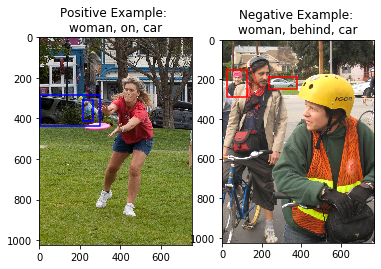

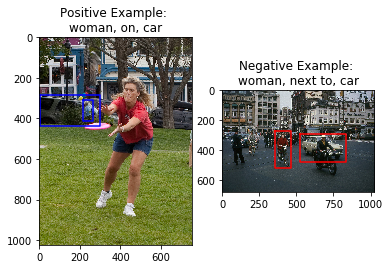

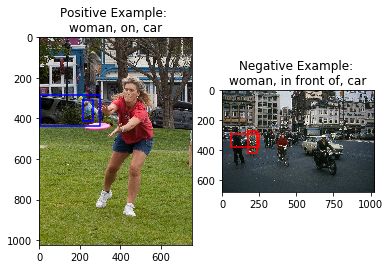

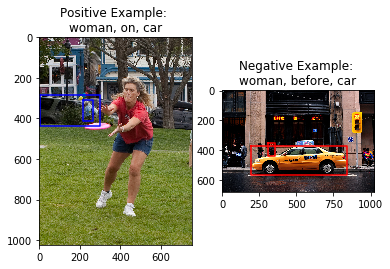

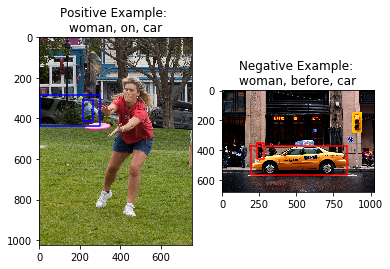

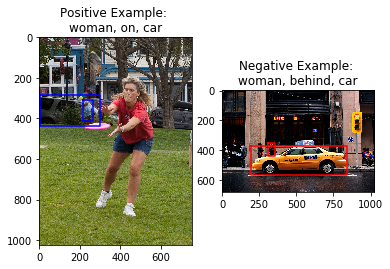

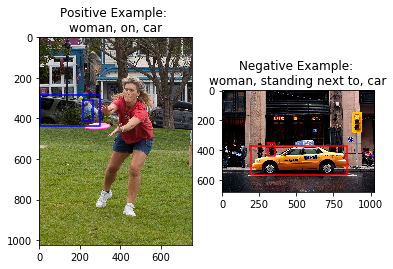

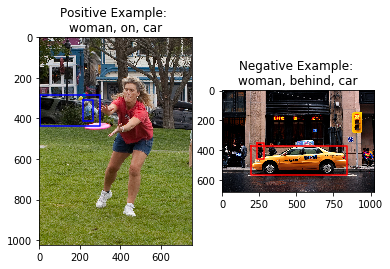

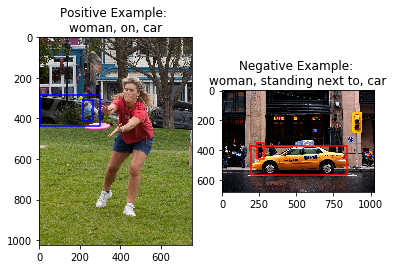

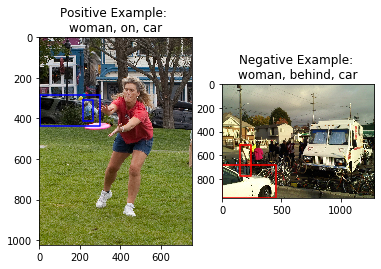

In [27]:
#Just enter filename
filename = "on_test_triplets.json"

visualizeDataset(filename)